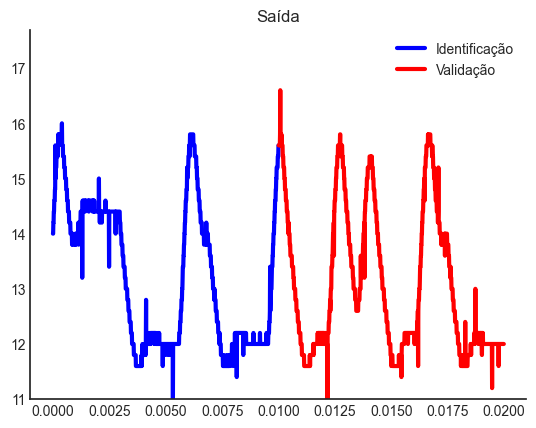

In [22]:
"""
Implementação da IM aplicada na estimação dos parâmetros
Autor: Gabriel Bueno Leandro
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective.im import IM
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error
# Lendo os dados de entrada e saída do Buck
dados = pd.read_csv("buck.txt" , sep=" ", header=None).to_numpy()
dados_val = pd.read_csv("buck_val.txt" , sep =" ", header=None).to_numpy()

# Separando os dados de identificação
dados_amostras = dados[:, 2]
dados_saida = dados[:, 6]
dados_entrada = dados[:, 4]

# Separando os dados de validação
dados_amostras_val = dados_val[:, 2]
dados_saida_val = dados_val[:, 6]
dados_entrada_val = dados_val[:, 4]

# Plotando a saída medida(dados de identificação e validação)
plt.figure(1)
plt.title('Saída')
plt.plot(dados_amostras,dados_saida, 'b', label='Identificação', linewidth=3)
plt.plot(dados_amostras_val,dados_saida_val, 'r', label='Validação', linewidth=3)
plt.ylim(11, 17.7)
plt.legend()
plt.show()

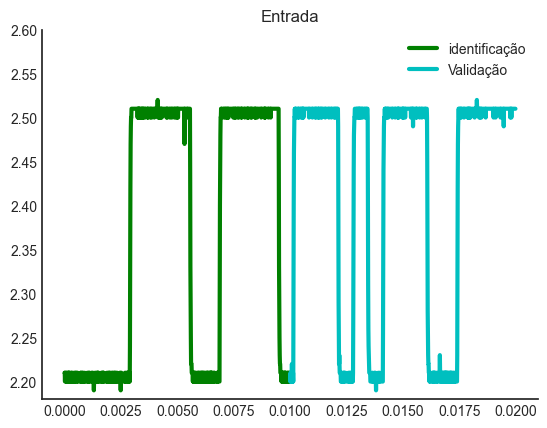

In [23]:
# Plotando a entrada medida(dados de identificação e validação)
plt.figure(2)
plt.title('Entrada')
plt.plot(dados_amostras, dados_entrada, 'g', label='identificação',
         linewidth=3)
plt.plot(dados_amostras_val, dados_entrada_val, 'c', label='Validação',
         linewidth=3)
plt.legend()
plt.ylim(2.18, 2.6)
plt.show()

## Função Estática do Conversor CC-BUCK

A equação que descreve o comportamento dinâmico do conversor Buck é:

$$
V_o = \frac{4V_d}{3} - \frac{V_d}{3}\cdot \bar{u}
$$

ao assumir $V_d = 24\:V $, a expressão pode ser reescrita da seguinte forma: 

$$
V_o = (4 - \bar{u})\cdot 8
$$

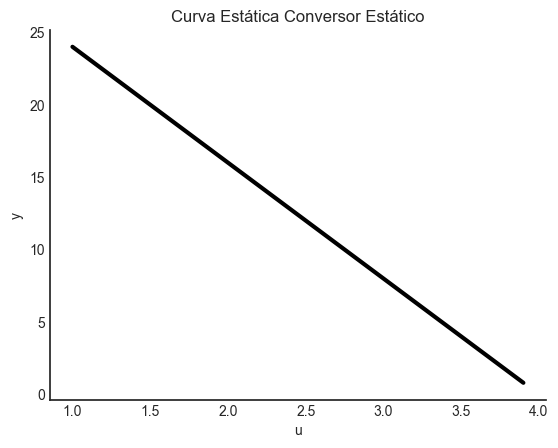

In [24]:
# Dados estáticos
Vd = 24
Yo = np.zeros(30)
Uo = np.zeros(30)
for t in range(10, 40):
    Uo[t-10] = (t)/10
    Yo[t-10] = (4-Uo[t-10])*Vd/3
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
plt.figure(3)
plt.title('Curva Estática Conversor Estático')
plt.xlabel('u')
plt.ylabel('y')
plt.plot(Uo, Yo, 'k', linewidth=3)
plt.show()

o ganho do conversor Buck pode ser descrito como a tensão de saída sobre a de entrada:

$$
gain = \frac{Vo}{Vd}
$$
ao considerar a tensão de entrada constante em $V_d = 24\:V$:

$$
gain = \frac{Vo}{24}
$$

abaixo será plotado o ganho:

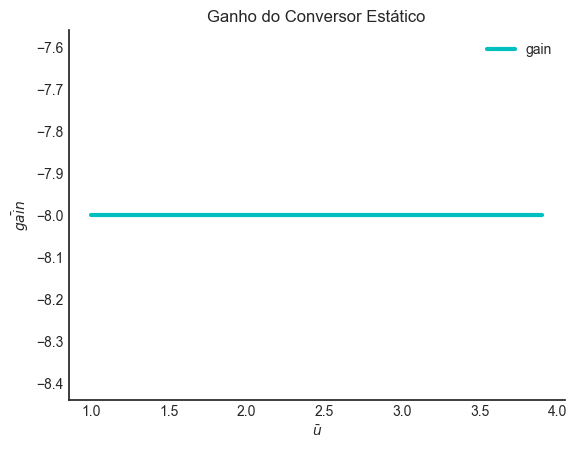

In [25]:
# Definindo o ganho
gain = -8*np.ones(len(Uo)).reshape(-1, 1)
plt.figure(3)
plt.title('Ganho do Conversor Estático')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{gain}$')
plt.plot(Uo, gain, 'c', linewidth=3, label='gain')
plt.legend()
plt.show()

a ideia seria tentar combinar a função estática, ganho etático e a reposta dinâmica do Conversor CC Buck:

$$
\gamma(\hat\theta) = w_1\cdot J_{LS}(\hat{\theta})+w_2\cdot J_{SF}(\hat{\theta})+w_3\cdot J_{SG}(\hat{\theta})
$$

para tal, se faz necessário conhecer a estrurura do modelo NARX polinomial a ser empregado.

In [26]:
# Informando os dados de teste e validação.
x_train = dados_entrada.reshape(-1, 1)
y_train = dados_saida.reshape(-1, 1)
x_valid = dados_entrada_val.reshape(-1, 1)
y_valid = dados_saida_val.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

próximo passo será determinar os pesos dos objetivos de interesse:

In [27]:
# Matriz com os pesos
W = np.array([[0.98, 0.7, 0.5, 0.35, 0.25, 0.01, 0.15, 0.01],
              [0.01, 0.1, 0.3, 0.15, 0.25, 0.98, 0.35, 0.01],
              [0.01, 0.2, 0.2, 0.50, 0.50, 0.01, 0.50, 0.98]])

com os parâmetros todos em maõs, já podemos calcular os parâmetros de forma multiobjetivo:

In [28]:
# Chamando a classe referente ao cálculo dos parâmetros via técnica multiobjetivo
g = IM(y_train=y_train[2:],
       Gain=gain,Y_static=Yo,
       X_static=Uo, PSI=model.psi,
       n_inputs=model._n_inputs,
       non_degree=model.non_degree,
       model_type=model.model_type,
       final_model = model.final_model)

agora será chamado o método para calcular a matriz do desempenho dos objetivos (J), pesos (w), a norma euclidiana (E), os thetas referente a cada peso (Theta), matriz H multiplicada por R e a matriz Q multiplicada por R. 

In [29]:
# Método para calcular os parâmetros
J, w, E, Theta, HR, QR = g.multio()
result = {'w1': w[0,:],
          'w2': w[2,:],
          'w3': w[1,:],
          'J_ls': J[0,:],
          'J_sg': J[1,:],
          'J_sf': J[2,:],
          '||J||:': E}
print(pd.DataFrame(result))

       w1    w2    w3       J_ls      J_sg      J_sf     ||J||:
0    0.01  0.04  0.95  17.388827  0.006062  0.000114  17.388828
1    0.01  0.09  0.90  17.414158  0.001247  0.000129  17.414158
2    0.01  0.14  0.85  17.421047  0.000520  0.000142  17.421047
3    0.01  0.19  0.80  17.423821  0.000283  0.000154  17.423821
4    0.01  0.24  0.75  17.424982  0.000178  0.000168  17.424982
..    ...   ...   ...        ...       ...       ...        ...
185  0.81  0.09  0.10  16.666319  0.323271  0.947032  16.696333
186  0.81  0.14  0.05  16.624472  0.056328  1.819063  16.723793
187  0.86  0.04  0.10  16.656832  0.908990  0.681740  16.695541
188  0.86  0.09  0.05  16.622631  0.116514  1.716667  16.711444
189  0.91  0.04  0.05  16.623959  0.369748  1.399089  16.686826

[190 rows x 7 columns]


agora podemos escolher um valor de theta referente aos pesos:

In [30]:
# Escrevendo os resultados
model.theta = Theta[6, :].reshape(-1,1)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=3, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

      Regressors   Parameters        ERR
0         y(k-1)   3.7168E-01  9.999E-01
1         y(k-2)   6.2871E-01  2.042E-05
2  x1(k-1)y(k-1)  -4.6096E-04  1.108E-06
3              1   5.0995E-03  4.688E-06
4       y(k-1)^2   3.0043E-01  3.922E-07
5        x1(k-1)   4.4740E-04  8.389E-07
6   y(k-2)y(k-1)  -5.8422E-01  5.690E-07
7       y(k-2)^2   2.8379E-01  3.827E-06


os dados dinâmicos em forma gráfica:

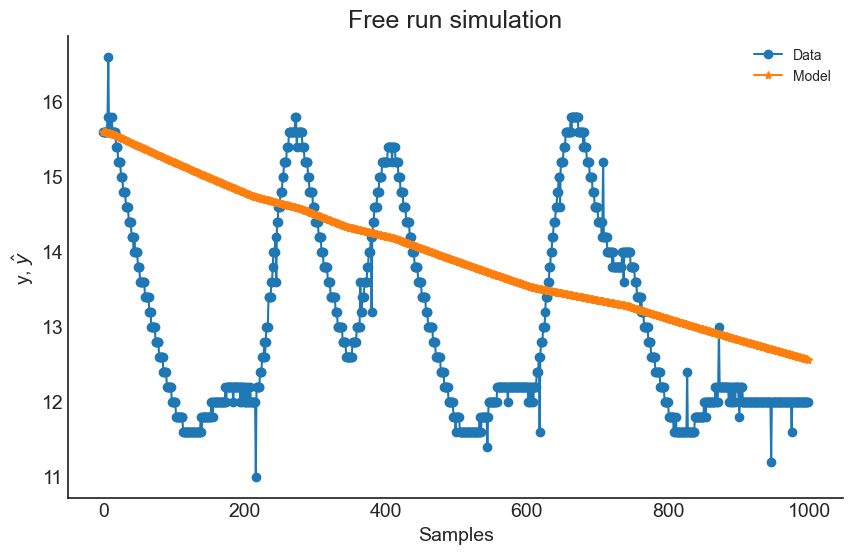

In [31]:
plot_results(y=y_valid, yhat=yhat, n=1000)

o ganho estático de forma gráfica:

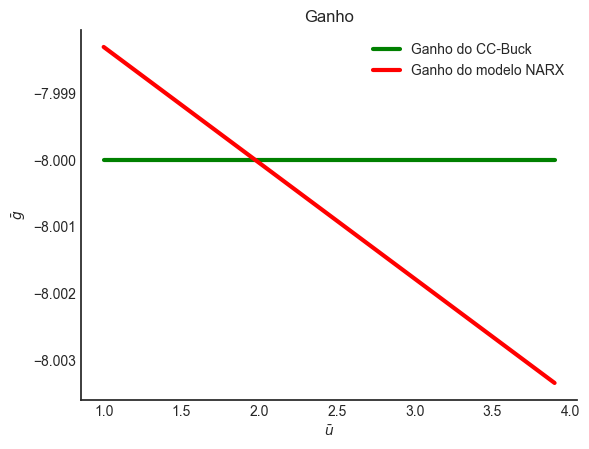

In [32]:
plt.figure(4)
plt.title('Ganho')
plt.plot(Uo, gain, 'g', linewidth=3, label='Ganho do CC-Buck')
plt.plot(Uo, HR.dot(model.theta), 'r', linewidth=3, label='Ganho do modelo NARX')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{g}$')
plt.legend()
plt.show()

a função estática de forma gráfica:

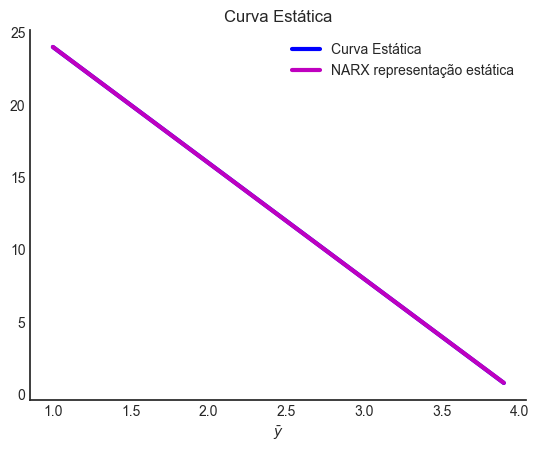

In [33]:
plt.figure(5)
plt.title('Curva Estática')
plt.plot(Uo, Yo, 'b', linewidth=3, label='Curva Estática')
plt.plot(Uo, QR.dot(model.theta), 'm', linewidth=3, label='NARX representação estática')
plt.xlabel('$\\bar{u}$')
plt.xlabel('$\\bar{y}$')
plt.legend()
plt.show()

curva de pareto-ótimo:

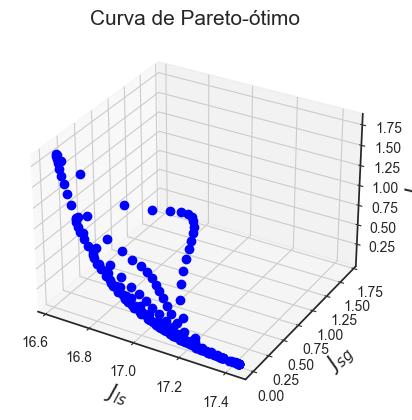

In [34]:
plt.figure(6)
ax = plt.axes(projection='3d')
ax.plot3D( J[0,:],  J[1,:],  J[2,:], 'bo', linewidth=2)
ax.set_title('Curva de Pareto-ótimo', fontsize=15)
ax.set_xlabel('$J_{ls}$', fontsize=15)
ax.set_ylabel('$J_{sg}$', fontsize=15)
ax.set_zlabel('$J_{sf}$', fontsize=15)
plt.show()